In [29]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

s3= boto3.resource('s3')
bucket_name = "rachaeld-data445"
bucket= s3.Bucket(bucket_name)

file_key= 'Mall_Customers.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
customers = pd.read_csv(file_content_stream)
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [31]:
customers = customers.dropna()
customers

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [32]:
#change Gender Male/Female to 1/0
customers['Gender'].replace(['Male', 'Female'], [1,0], inplace= True)

# min-max transformation
scaler = MinMaxScaler()

customers[['Age_01', 'Annual_Income_01']] = scaler.fit_transform(customers[['Age', 'Annual Income (k$)']])
customers.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_01,Annual_Income_01
0,1,1,19,15,39,0.019231,0.000000
1,2,1,21,15,81,0.057692,0.000000
2,3,0,20,16,6,0.038462,0.008197
3,4,0,23,16,77,0.096154,0.008197
4,5,0,31,17,40,0.250000,0.016393
5,6,0,22,17,76,0.076923,0.016393
6,7,0,35,18,6,0.326923,0.024590
7,8,0,23,18,94,0.096154,0.024590
8,9,1,64,19,3,0.884615,0.032787
9,10,0,30,19,72,0.230769,0.032787


In [33]:
X = customers[['Gender', 'Age_01', 'Annual_Income_01']]

#number of clusters
kclusters = [2,3,4,5,6,7,8,9,10]

#storing the scores
CalHar_score = list()
DavBou_score = list()
Sil_score = list()

for i in kclusters:
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(X)
    
    # storing CalHar score
    CalHar= calinski_harabasz_score(X, kmeans_md.labels_)
    CalHar_score.append(CalHar)
    
    # storing DavBou score
    DavBou= davies_bouldin_score(X, kmeans_md.labels_)
    DavBou_score.append(DavBou)
    
    #storing Silhouette score 
    Sil = silhouette_score(X, kmeans_md.labels_)
    Sil_score.append(Sil)


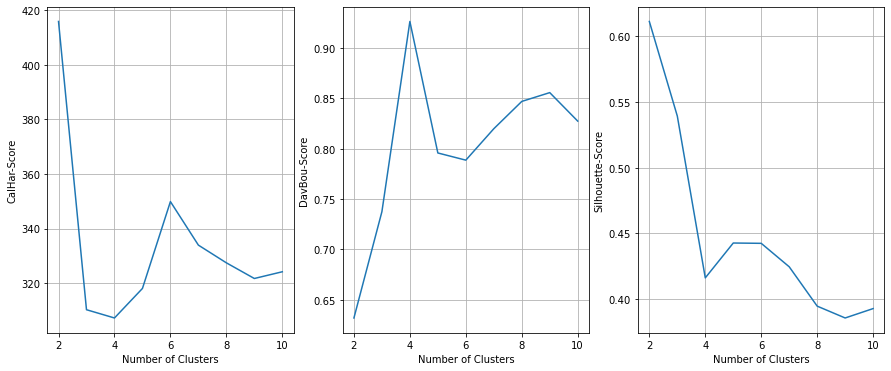

In [34]:
##visualizing 
fig, axs = plt.subplots(1, 3, figsize = (15, 6))

axs[0].plot(kclusters, CalHar_score)
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('CalHar-Score')
axs[0].grid()

axs[1].plot(kclusters, DavBou_score)
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('DavBou-Score')
axs[1].grid()

axs[2].plot(kclusters, Sil_score)
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

##the CalHar test shows having two clusters as the best
##the DavBou test shows having four clusters as the best
##the Silhouette test shows having 2 clusters as the best
## because 2/3 of the models are saying to use two clusters, I am going to use 2 

In [35]:
##clustering using 2 clusters
two_clust = KMeans(n_clusters = 2, n_init = 20).fit(X)

##appending 
customers['cluster'] = two_clust.labels_
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_01,Annual_Income_01,cluster
0,1,1,19,15,39,0.019231,0.000000,1
1,2,1,21,15,81,0.057692,0.000000,1
2,3,0,20,16,6,0.038462,0.008197,0
3,4,0,23,16,77,0.096154,0.008197,0
4,5,0,31,17,40,0.250000,0.016393,0


In [38]:
##cluster 0
cluster_0 = customers[customers['cluster'] == 0].reset_index(drop = True)
cluster_0.describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_01,Annual_Income_01,cluster
count,112.000000,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.0
mean,97.562500,0.0,38.098214,59.250000,51.526786,0.386504,0.362705,0.0
std,58.276412,0.0,12.644095,26.011952,24.114950,0.243156,0.213213,0.0
min,3.000000,0.0,18.000000,16.000000,5.000000,0.000000,0.008197,0.0
25%,46.750000,0.0,29.000000,39.750000,35.000000,0.211538,0.202869,0.0
50%,94.500000,0.0,35.000000,60.000000,50.000000,0.326923,0.368852,0.0
75%,148.250000,0.0,47.500000,77.250000,73.000000,0.567308,0.510246,0.0
max,197.000000,0.0,68.000000,126.000000,99.000000,0.961538,0.909836,0.0


In [39]:
##cluster 1 
cluster_1 = customers[customers['cluster'] == 1].reset_index(drop = True)
cluster_1.describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_01,Annual_Income_01,cluster
count,88.000000,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.0
mean,104.238636,1.0,39.806818,62.227273,48.511364,0.419362,0.387109,1.0
std,57.483830,0.0,15.514812,26.638373,27.896770,0.298362,0.218347,0.0
min,1.000000,1.0,18.000000,15.000000,1.000000,0.000000,0.000000,1.0
25%,59.500000,1.0,27.750000,45.500000,24.500000,0.187500,0.250000,1.0
50%,106.500000,1.0,37.000000,62.500000,50.000000,0.365385,0.389344,1.0
75%,151.250000,1.0,50.500000,78.000000,70.000000,0.625000,0.516393,1.0
max,200.000000,1.0,70.000000,137.000000,97.000000,1.000000,1.000000,1.0
